In [4]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
import numpy as np
import os
import re
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
root_path = 'log/'

legend_font = {'family' : 'Times New Roman',
    'weight' : 'normal',
    'size'   : 12,
    }
font = {'family' : 'Times New Roman',
    'weight' : 'normal',
    'size'   : 15,
    }

colorlist = ['darkorange', 'cyan', 'lightsteelblue', 'plum', 'darkseagreen', 'gold', 'bisque', 'lightgreen', 'gray']
color_rgb_list = [(74/255, 135/255, 161/255), (222/255, 144/255, 123/255), (230/255, 197/255, 180/255), (88/255, 141/255, 106/255), (147/255, 196/255, 212/255), (237/255, 204/255, 134/255), (156/255, 131/255, 131/255), (116/255, 126/255, 73/255), (61/255, 71/255, 59/255), (36/255, 74/255, 96/255)]

def extract_number(feature, data, split_str):
    result_list = []
    for line in data:
        #print(line)
        seg = re.split(split_str, line)
        if set(feature).issubset(set(seg)):
            for item in seg:
                if item.lstrip('-').replace('.', '').replace(',', '').isdigit():
                    item = item.replace(',', '')
                    try:
                        result_list.append(int(item))  
                    except ValueError:
                        result_list.append(float(item))  
                        
    return result_list
                
def process_log(root_path, log_path, steps_feature = ['components'], \
                steps_split = ' |\n', val_split = ' |\n|\)|\(|%', val_features = ['set:', 'Accuracy:', 'Test']):
    with open(root_path + log_path, 'r') as f:
        data = f.readlines()
        steps_list = extract_number(feature = steps_feature, data = data, split_str = steps_split)
        val_list = extract_number(feature = val_features, data = data, split_str = val_split) 
    
    
    if abs(len(steps_list) -  len(val_list)) == 1:
        min_len = min(len(steps_list), len(val_list))
        return steps_list[:min_len], val_list[:min_len]
    else:
        return steps_list, val_list

def process_smooth(steps_list, val_list, smooth_len):
    steps = [0] * len(range(0, len(steps_list)-smooth_len+1, smooth_len))
    vals = [0] * len(steps)
    for i in range(0, len(steps_list)-smooth_len+1, smooth_len):
        steps[i // smooth_len]  = steps_list[i+np.argmin(val_list[i:i+smooth_len])]
        vals[i // smooth_len] = np.min(val_list[i:i+smooth_len])
    return steps, vals

In [5]:
def smooth(r_list,plot_list_len,smooth_len):
    plot_list = []
    for i in range(plot_list_len):
        plot_list.append(np.mean(r_list[i*smooth_len:(i+1)*smooth_len]))
    return plot_list

/tmp/ipykernel_1237692/922030050.py:99: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='major',axis='y',linewidth=0.4 )


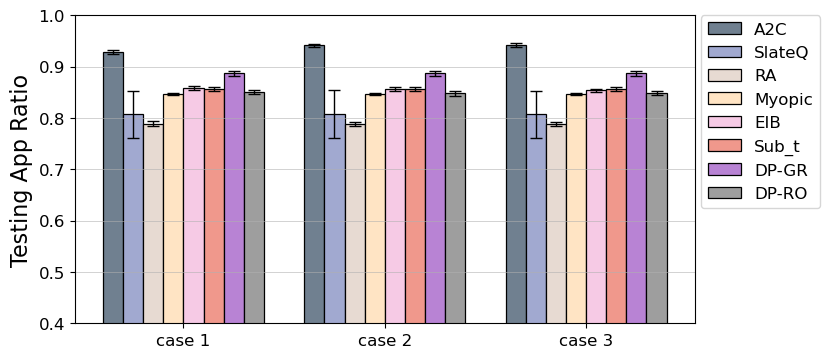

In [9]:
case_file = 'GT/rlN=10M=4k=0.03L=100T=500/'

UB_files = ['UB_INV12C4prod','UB_INV12C4cus','UB_INV12C4rand']
names=['GT/rlN=10M=4k=0.03L=100T=500/Benchmark_INV12prod',
       'GT/rlN=10M=4k=0.03L=100T=500/Benchmark_INV12cus',
       'GT/rlN=10M=4k=0.03L=100T=500/Benchmark_INV12rand']
net = ['rlN=10M=4k=0.03L=100T=500INV=12RNNmcprod/DRLTrainLog2024-12-06-21-03-36',
       'rlN=10M=4k=0.03L=100T=500INV=12RNNmccus/DRLTrainLog2024-12-06-21-03-46',
       'rlN=10M=4k=0.03L=100T=500INV=12RNNmcrand/DRLTrainLog2024-12-12-23-28-18']
DQN = ['rlN=10M=4k=0.03L=100T=500INV=12DQNmcprod/' + 'DRLTrainLog2024-11-26-20-20-27',
       'rlN=10M=4k=0.03L=100T=500INV=12DQNmccus/' + 'DRLTrainLog2024-11-26-20-20-41',
       'rlN=10M=4k=0.03L=100T=500INV=12DQNmcrand/' + 'DRLTrainLog2024-11-26-20-27-03']
labels = ['case 1','case 2','case 3']

colors=['slategray','#A1A9D0','#E7DAD2','bisque','#F6CAE5','#F0988C','#B883D4','#9E9E9E']
datas = []
for i in range(8):
    datas.append([])
error = []
for i in range(8):
    error.append([])
for i in range(3):
    UB_file = case_file+UB_files[i]
    with open(UB_file, 'r') as f:
        data = f.readlines()
        train_opt_here = []
        test_opt_here = []
        for line in data:
            if 'training upper bound' in line:
                train_opt_here.append(float(line.split(':')[-1]))
            if 'testing upper bound' in line:
                test_opt_here.append(float(line.split(':')[-1]))
    train_opt_here = np.mean(train_opt_here)
    test_opt_here = np.mean(test_opt_here)

    with open(r'log/'+ DQN[i], 'r') as f:
        data = f.readlines()
        DQNseller_list = []
        for line in data:
            if 'mean test reward:' in line:
                DQNseller_list.append(float(line.split(',')[-1][-8:])/test_opt_here)
    with open(names[i], 'r') as f:
        data = f.readlines()
        Random_list = []
        Myopic_list = []
        EIB_list = []
        Sub_t_list = []
        DP_Greedy_list = []
        DP_Rollout_list = []
        for line in data:
            if 'mean test reward:' in line:
                Random_list.append(float(line.split(',')[-6])/test_opt_here)
                Myopic_list.append(float(line.split(',')[-5])/test_opt_here)
                EIB_list.append(float(line.split(',')[-4])/test_opt_here)
                Sub_t_list.append(float(line.split(',')[-3])/test_opt_here)
                DP_Greedy_list.append(float(line.split(',')[-2])/test_opt_here)
                DP_Rollout_list.append(float(line.split(',')[-1])/test_opt_here)
        datas[1].append(np.mean(DQNseller_list))
        datas[2].append(np.mean(Random_list))
        datas[3].append(np.mean(Myopic_list))
        datas[4].append(np.mean(EIB_list))
        datas[5].append(np.mean(Sub_t_list))
        datas[6].append(np.mean(DP_Greedy_list))
        datas[7].append(np.mean(DP_Rollout_list))
        error[1].append(np.array(DQNseller_list).std())
        error[2].append(np.array(Random_list).std())
        error[3].append(np.array(Myopic_list).std())
        error[4].append(np.array(EIB_list).std())
        error[5].append(np.array(Sub_t_list).std())
        error[6].append(np.array(DP_Greedy_list).std())
        error[7].append(np.array(DP_Rollout_list).std())
    with open(r'log/' + net[i], 'r') as f:
        data = f.readlines()
        seller_list = []
        for line in data:
            if 'mean test reward:' in line:
                seller_list.append(float(line.split(',')[-7][-8:])/test_opt_here)
        datas[0].append(np.mean(seller_list))
        error[0].append(np.array(seller_list).std())
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))    
error_params=dict(elinewidth=1,ecolor='black',capsize=4)#设置误差标记参数
# 四组数据
x = np.arange(len(labels))  # x轴刻度标签位置
width = 0.1  # 柱子的宽度
# 计算每个柱子在x轴上的位置，保证x轴刻度标签居中
ax.bar(x - 3.5*width, datas[0], width, label='A2C',color = colors[0],edgecolor='black',linewidth=0.9,yerr=error[0],error_kw=error_params)
ax.bar(x - 2.5*width, datas[1], width, label='SlateQ',color = colors[1],edgecolor='black',linewidth=0.9,yerr=error[1],error_kw=error_params)
ax.bar(x - 1.5*width, datas[2], width, label='RA',color = colors[2],edgecolor='black',linewidth=0.9,yerr=error[2],error_kw=error_params)
ax.bar(x - 0.5*width, datas[3], width, label='Myopic',color = colors[3],edgecolor='black',linewidth=0.9,yerr=error[3],error_kw=error_params)
ax.bar(x + 0.5*width, datas[4], width, label='EIB',color = colors[4],edgecolor='black',linewidth=0.9,yerr=error[4],error_kw=error_params)
ax.bar(x + 1.5*width, datas[5], width, label='Sub_t',color = colors[5],edgecolor='black',linewidth=0.9,yerr=error[5],error_kw=error_params)
ax.bar(x + 2.5*width, datas[6], width, label='DP-GR',color = colors[6],edgecolor='black',linewidth=0.9,yerr=error[6],error_kw=error_params)
ax.bar(x + 3.5*width, datas[7], width, label='DP-RO',color = colors[7],edgecolor='black',linewidth=0.9,yerr=error[7],error_kw=error_params)
ax.set_ylim(0.4,1)
#ax.set_yticks(range(140,310,40),size=12)
plt.ylabel('Testing App Ratio',size=16)
plt.tick_params(axis='x',labelsize=12)
plt.tick_params(axis='y',labelsize=12)
plt.grid(b=True, which='major',axis='y',linewidth=0.4 )
# x轴刻度标签位置不进行计算
plt.xticks(x, labels=labels)
plt.legend(prop = {'size':12}, bbox_to_anchor=(1.01,1),borderaxespad = 0.)
plt.savefig(r'plot/'+'reuse_'+'test'+'.pdf', dpi=600, format='pdf',bbox_inches = 'tight')
plt.show();

/tmp/ipykernel_1237692/4223596798.py:56: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='major',axis='y',linewidth=0.4 )


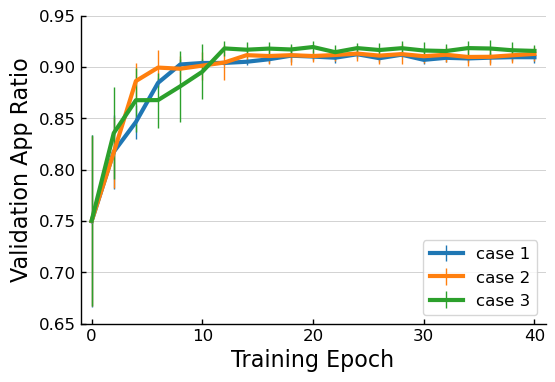

In [7]:
names = ['rlN=10M=4k=0.03L=100T=500INV=12RNNmcprod/DRLTrainLog2024-12-06-21-03-36',
       'rlN=10M=4k=0.03L=100T=500INV=12RNNmccus/DRLTrainLog2024-12-06-21-03-46',
       'rlN=10M=4k=0.03L=100T=500INV=12RNNmcrand/DRLTrainLog2024-12-12-23-28-18']
labels = ['case 1','case 2','case 3']#random product cus
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
for i in range(3):
    UB_file = case_file+UB_files[i]
    with open(UB_file, 'r') as f:
        data = f.readlines()
        train_opt_here = []
        test_opt_here = []
        for line in data:
            if 'training upper bound' in line:
                train_opt_here.append(float(line.split(':')[-1]))
            if 'testing upper bound' in line:
                test_opt_here.append(float(line.split(':')[-1]))
    train_opt_here = np.mean(train_opt_here)
    test_opt_here = np.mean(test_opt_here)
    
    list_ = []
    with open(r'log/' + names[i], 'r') as f:
        data = f.readlines()
        result_list = []
        for line in data:
            if 'initial mean reward' in line:
                seg = re.split(' |\n', line)[-2]
                result_list.append(float(seg)/train_opt_here)
            if 'validate reward:' in line:
                seg = re.split(' |\n', line)[-2]
                result_list.append(float(seg)/train_opt_here)
            if 'completed' in line:
                list_.append(result_list[:41])
                result_list = []
    list_ = list_[:-1]
    list_ = np.array(list_) 
    y = list_.mean(0)
    err = list_.std(0)
    steps = np.arange(41)
    x_major_locator=MultipleLocator(4)
    ax1.xaxis.set_major_locator(x_major_locator)
    ax1.errorbar(steps[::2], y[::2], yerr=err[::2],errorevery=1,elinewidth=1
                 ,linewidth=3,label = labels[i])#linestyle=lines[i] ,
ax1.set_xlabel("Training Epoch",size=16)
ax1.set_ylabel('Validation App Ratio',size=16)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_linewidth(1);###设置底部坐标轴的粗细
ax1.spines['left'].set_linewidth(1);####设置左边坐标轴的粗细
ax1.tick_params(direction='in', width=1)
ax1.set_xlim(-1,41)
ax1.set_ylim(0.65,0.95)
ax1.set_xticks(steps[::10],size=12)
#ax1.set_yticks(range(150,320,30),size=12)
plt.tick_params(axis='x',labelsize=12)
plt.tick_params(axis='y',labelsize=12)
plt.grid(b=True, which='major',axis='y',linewidth=0.4 )
plt.legend(prop = {'size':12},loc='lower right')
plt.savefig(r'plot/'+'reuse_'+'train'+'.pdf', dpi=600, format='pdf',bbox_inches = 'tight')           
plt.show();